In [1]:
%reload_ext autoreload
%autoreload 2


# Introduction

This is a Pytorch model based on VGG16 architecture for CIFAR-10. it can be used either with pretrained weights file or trained from scratch.

The architecture is based on the VGG-16 [1]. By running the py files you can get a sample of a training and estimation of validation error.

The CIFAR-10 reaches a validation accuracy of 93.56%. On instantiation the model can either be trained or loaded from previous saved weight file.

References:

[1] Karen Simonyan and Andrew Zisserman. Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556, 2014.

[2] https://github.com/geifmany/cifar-vgg

[3] https://github.com/chengyangfu/pytorch-vgg-cifar10

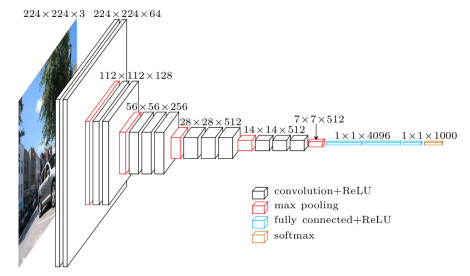

# Import libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import seaborn as sns
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import Subset
from tqdm import tqdm

from operator_norm import  *

import json
from copy import deepcopy




In [ ]:
isMac = False

if isMac:
    print(f"PyTorch version: {torch.__version__}")

    # Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")

    # Set the device      
    device = "mps" if torch.backends.mps.is_available() else "cpu"
else:
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')


print(f"Using device: {device}")

Using device: cuda


In [ ]:
BATCH_SIZE=64
num_epochs=5
lr=1e-4
class_size=10
input_shape = (32,32)

In [ ]:
def load_data(batchsize,input_shape = input_shape):

    tranform_train = transforms.Compose([transforms.Resize(input_shape), transforms.RandomHorizontalFlip(p=0.7), transforms.ToTensor(), transforms.Normalize(mean=[0.406], std=[0.225])])
    tranform_test = transforms.Compose([transforms.Resize(input_shape), transforms.ToTensor(), transforms.Normalize(mean=[0.406], std=[0.225])])

    #prep the train, validation and test dataset
    torch.manual_seed(2021)
    train = torchvision.datasets.FashionMNIST("data/", train=True, download=True, transform=tranform_train) 
    val_size = 1000
    train_size = len(train) - val_size
    train, val = random_split(train, [train_size, val_size]) 
    test = torchvision.datasets.FashionMNIST("data/", train=False, download=True, transform=tranform_test) 

    #  train, val and test datasets to the dataloader
    train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader,val_loader, test_loader
train_loader,val_loader, test_loader = load_data(BATCH_SIZE,input_shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 1, 32, 32])


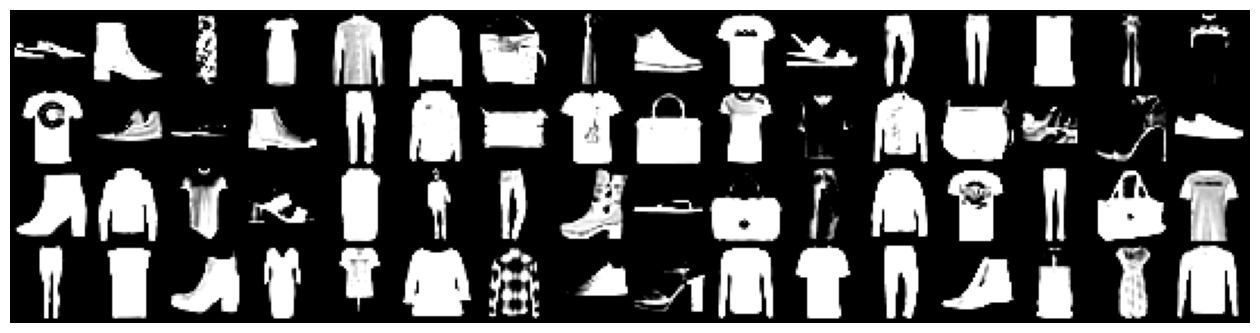

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

#### Unseen layers VGG employs ReLU in all of its secret layers (AlexNet came up with a big idea that sliced training time in half.). Local Response Normalization (LRN) is not used by VGG because It improves memory retention and training time while providing little improvement inaccuracy.

In [ ]:
### Utils functions to build a parametrized NN

def conv_shape(x, k=1, p=0, s=1, ):
    return int((x + 2*p - k)/s + 1)

def classifier_input_shape( cfg, nchannels, input_shape):
    l = input_shape[0]
    
    res = nchannels
    for x in cfg:
        if x == 'A':
            l = conv_shape(l, k=2,s=2)//2
        elif x == 'M':
            l = conv_shape(l, k=4,s=4)*2
        else:
            res = x
        
    return res * l**2

def make_layers(cfg, in_channels):
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'A':
            layers += [nn.MaxPool2d(kernel_size=4, stride=4)]
        else: #nn.BatchNorm2d(v)
            layers += [nn.Conv2d(in_channels, v, kernel_size=3, padding=1), nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [ ]:
## Model

class Network(nn.Module):
    def __init__(self,cfg = [16, 16,'A',32,'A'],input_shape = input_shape, nchannels = 1, nclasses = 10):
        super(Network, self).__init__()
        
        self.conv = make_layers(cfg, nchannels)
        n = classifier_input_shape(cfg, nchannels, input_shape) 
        k=min(n//2,126)
        self.classifier = nn.Sequential(nn.Linear( n, k ), 
                                        nn.ReLU(inplace=True), 
                                        nn.Dropout(0.5), 
                                        nn.Linear( k, nclasses))

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    

In [ ]:
CFG = [16,32,'A',32]
model = Network(cfg=CFG)


In [ ]:
norm=singular_values(model.conv[0].weight.data,input_shape).max()
print('Initial norm of the first Conv layer :', norm)
norm=singular_values(model.classifier[0].weight.data,conv=False).max()
print('Initial norm of the first Linear layer :', norm)
print('\n')
clip_model_weights(model,input_shape)
norm=singular_values(model.conv[0].weight.data,input_shape).max()
print('Norm of the first Conv layer after clipping :', norm)
norm=singular_values(model.classifier[0].weight.data,conv=False).max()
print('Norm of the first Linear layer after clipping :', norm)


Initial norm of the first Conv layer : 3.0102397973694592
Initial norm of the first Linear layer : 0.7122902


Norm of the first Conv layer after clipping : 1.0009002102297968
Norm of the first Linear layer after clipping : 1.0


In [ ]:
# Training loop

def train(model,num_epochs, train_loader=train_loader, val_loader=val_loader, printer=True):
    model.to(device=device) 
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= lr) 
    for epoch in range(num_epochs): #I decided to train the model for 50 epochs
        loss_var = 0
        
        for idx, (images, labels) in enumerate(train_loader):
            images = images.to(device=device)
            labels = labels.to(device=device)
            ## Forward Pass
            optimizer.zero_grad()
            scores = model(images)
            loss = criterion(scores,labels)
            loss.backward()
            optimizer.step()
            loss_var += loss.item()

            if idx%64==0 and printer:
                print(f'Epoch [{epoch+1}/{num_epochs}] || Step [{idx+1}/{len(train_loader)}] || Loss:{loss_var/len(train_loader)}')
        print(f"Loss at epoch {epoch+1} || {loss_var/len(train_loader)}")

        with torch.no_grad():
            correct = 0
            samples = 0
            for idx, (images, labels) in enumerate(val_loader):
                images = images.to(device=device)
                labels = labels.to(device=device)
                outputs = model(images)
                _, preds = outputs.max(1)
                correct += (preds == labels).sum()
                samples += preds.size(0)
            print(f"accuracy {float(correct) / float(samples) * 100:.2f} percentage || Correct {correct} out of {samples} samples")

In [ ]:
#TESTING LOOP SIMILAR TO VALIDATION(EVAL)

def eval(model, test_loader):
    correct = 0
    samples = 0
    model.eval()
    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            # labels = labels.to(device='cpu')
            outputs = model(images)
            _, preds = outputs.max(1)
            correct += (preds.cpu() == labels).sum()
            samples += preds.size(0)
        print(f"accuracy {float(correct) / float(samples) * 100:.2f} percentage || Correct {correct} out of {samples} samples")
    return correct.item()/samples


In [ ]:
# Toolkit functions to save the experiments
def save_data( new_key, new_value, json_file_path = 'final_results.json', overwrite=False):    
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    if not overwrite:
        i=1
        while new_key+str(i) in data:
            i+=1
        new_key+=str(i)
    data[new_key] = new_value
    with open(json_file_path, 'w') as file:
        json.dump(data, file, indent=2, default=str)

def to_dictionary(train_acc,test_acc,distance,n_param,cfg,batchsize,epochs,dataset_name='FASHION-MNIST'):
    return {'train_acc':train_acc,
    'test_acc': test_acc,
    'distance_to_initialization':distance,
    'n_param':n_param,
    'cfg':cfg,
    'batchsize':batchsize,
    'epochs':epochs,
    'dataset_name':dataset_name}

In [208]:

def pipeline(cfg,batchsize,epochs,input_shape=input_shape):
    train_loader,val_loader,test_loader = load_data(batchsize=batchsize,input_shape=input_shape)

    
    model = Network(cfg) 
    initial_model = deepcopy(model)
    
    train(model, num_epochs=epochs, train_loader=train_loader,val_loader=val_loader, printer=False)
    

    model.to(device)
    print('\n')

    print('FINAL TRAIN ACCURACY')
    train_acc = eval(model, train_loader)
    print('FINAL TEST ACCURACY')
    test_acc = eval(model,test_loader)
    print('\n')
    
    model.cpu()
    distance, n_param = metrics(initial_model,model,input_shape)
    new_key =f'MNIST-{batchsize}-{epochs}-{".".join([str(x) for x in cfg])}'
    save_data(new_key,to_dictionary(train_acc,test_acc,correct_test,n_sample_test,distance,n_param,cfg,batchsize,epochs))
    


            
        
        



In [207]:
pipeline(cfg = [16,36,'A'],batchsize = 64,epochs = 5)

Loss at epoch 1 || 0.9289871083487657
accuracy 79.19 percentage || Correct 7919 out of 10000 samples
accuracy 80.27 percentage || Correct 47359 out of 59000 samples


In [ ]:
for i in range(5):
    pipeline(cfg = [16,32,'A'],batchsize = 64,epochs = 5)